In [1]:
#importing necessary python packages
import pandas as pd
import numpy as np
import os

In [2]:
os.chdir('C:\\RESEARCH\\LUSC\\Regression') #setting the right directory

In [3]:
# Importing the dataset
dt = pd.read_excel('Gene Clinical.xlsx',index_col=0)


In [4]:
dt.shape

(501, 15171)

In [5]:
dt.head(2)

,UBE2Q2P2,SSX9,CXORF67,EFCAB8,SDR16C6P,EFCAB12,A1BG,A1CF,RBFOX1,GGACT,...,Tissue Source Site_MF,Tissue Source Site_NC,Tissue Source Site_NK,Tissue Source Site_O2,Tissue Source Site_XC,Vial number_A,Vial number_B,Patient's Vital Status_Alive,Patient's Vital Status_Dead,Overall Survival (Months)
Hugo_Symbol,,,,,,,,,,,,,,,,,,,,,
TCGA-18-3406-01,0.6275,-0.0763,-0.1111,-0.0210,-0.2073,-0.2939,6.0843,-0.1684,-0.1354,1.6552,...,0,0,0,0,0,1,0,0,1,12.19
TCGA-18-3407-01,-0.8280,-0.0763,-0.1111,-0.2912,-0.2073,-0.2723,-0.7020,0.3242,-0.1354,0.4132,...,0,0,0,0,0,1,0,0,1,4.47


In [6]:
del dt['Column1']
del dt['Patient\'s Vital Status_Dead']
del dt['Patient\'s Vital Status_Alive']

In [7]:
X = dt.iloc[:,0:15166].values
y = dt.iloc[:, -1].values

In [8]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

In [9]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
X_val = sc_X.fit_transform(X_val)

In [10]:
sc_y = StandardScaler()
y_train = np.squeeze(sc_y.fit_transform(y_train.reshape(-1, 1)))
y_val = np.squeeze(sc_y.transform(y_val.reshape(-1, 1)))
y_test = np.squeeze(sc_y.transform(y_test.reshape(-1, 1)))

In [11]:
# Fitting Simple Linear Regression to the Training set
from sklearn.linear_model import Ridge
regressor = Ridge()


regressor.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [12]:
#Predicting the Validation set results
y_predval = regressor.predict(X_val)

In [13]:
# Print result of MAE
from sklearn import metrics
print(metrics.mean_absolute_error(y_val, y_predval))

# Print result of MSE
print(metrics.mean_squared_error(y_val, y_predval))

# Print result of RMSE
print(np.sqrt(metrics.mean_squared_error(y_val, y_predval)))

# Explained variance score: 1 is perfect prediction (Accuracy Score)
print('Variance score: %.2f' % regressor.score(X_val, y_val))



0.762673359272848
0.9266156436762898
0.9626087697898299
Variance score: -0.02


R^2 = -0.0231


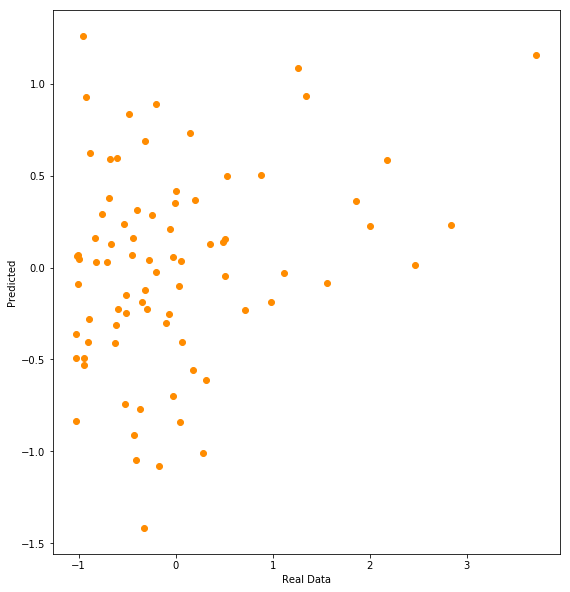

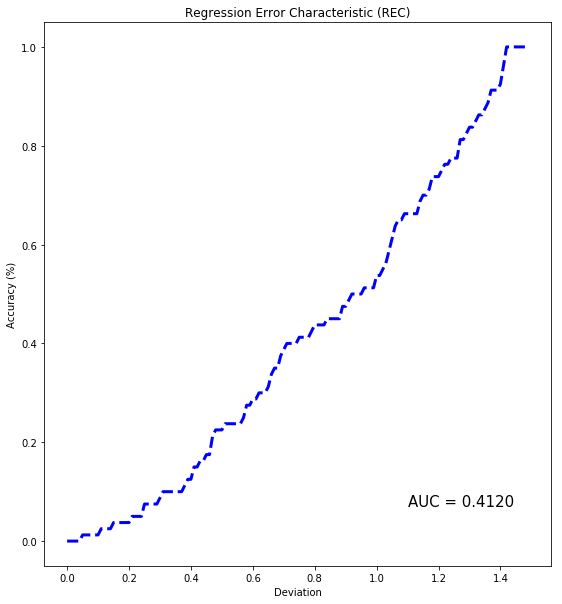

In [15]:
# Visualising the Random Forest Regression Results
# Loading Packages
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
#from sklearn import linear_model
from sklearn import datasets
from scipy.integrate import simps

# Function for Regression Error Characteritic Curve

def REC(y_val , y_predval):
    
    # initilizing the lists
    Accuracy = []
    
    # initializing the values for Epsilon
    Begin_Range = 0
    End_Range = 1.5
    Interval_Size = 0.01
    
    # List of epsilons
    Epsilon = np.arange(Begin_Range , End_Range , Interval_Size)
    
    # Main Loops
    for i in range(len(Epsilon)):
        count = 0.0
        for j in range(len(y_val)):
            if np.linalg.norm(y_val[j] - y_predval[j]) / np.sqrt( np.linalg.norm(y_val[j]) **2 + np.linalg.norm(y_predval[j])**2 ) < Epsilon[i]:
                count = count + 1
        
        Accuracy.append(count/len(y_val))
    
    # Calculating Area Under Curve using Simpson's rule
    AUC = simps(Accuracy , Epsilon ) / End_Range
        
    # returning epsilon , accuracy , area under curve    
    return Epsilon , Accuracy , AUC

# finding the deviation and accuracy, and area under curve for plotting
Deviation, Accuracy, AUC = REC(y_val, y_predval)

# Calculating R^2 of the true and predicted values
RR = r2_score(y_val, y_predval)

# Plotting
plt.figure(figsize=(20 , 10))

plt.subplot(1, 2, 1)
plt.scatter(y_val, y_predval,color = "darkorange")
plt.xlabel("Real Data")
plt.ylabel("Predicted")
plt.figure(figsize=(20 , 10))
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)
print("R^2 = %0.4f" %RR)


plt.subplot(1, 2, 2)
plt.title("Regression Error Characteristic (REC)")
plt.plot(Deviation, Accuracy, "--b",lw =3)
plt.xlabel("Deviation")
plt.ylabel("Accuracy (%)")
plt.text(1.1, 0.07, "AUC = %0.4f" %AUC , fontsize=15)


plt.show()